In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

sys.path.append(os.environ['DH_DIR'])

WDIR = os.environ['DM21CM_DIR']

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [22]:
from darkhistory.config import load_data
import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum

In [24]:
from read import read_pbh

In [46]:
# Mass threshold for mDM to annihilate into the primaries.
mass_threshold = {
    'elec_delta': phys.mass['e'], 'phot_delta': 0.,
    'e_L'   : phys.mass['e'],   'e_R': phys.mass['e'], 
    'e': phys.mass['e'],
    'mu_L'  : phys.mass['mu'], 'mu_R': phys.mass['mu'], 
    'mu': phys.mass['mu'],
    'tau_L' : phys.mass['tau'], 'tau_R' : phys.mass['tau'], 
    'tau': phys.mass['tau'],
    'q'     : 0.,             'c': phys.mass['c'],   
    'b'     : phys.mass['b'], 't': phys.mass['t'],
    'W_L': phys.mass['W'], 'W_T'   : phys.mass['W'], 'W': phys.mass['W'],
    'Z_L': phys.mass['Z'], 'Z_T'   : phys.mass['Z'], 'Z': phys.mass['Z'],
    'g': 0., 'gamma' : 0., 'h': phys.mass['h'],
    'nu_e': 0., 'nu_mu' : 0., 'nu_tau': 0.,
    'VV_to_4e'   : 2*phys.mass['e'], 'VV_to_4mu' : 2*phys.mass['mu'], 
    'VV_to_4tau' : 2*phys.mass['tau']
}

def get_pppc_spec(pri, pri_spec, sec, sec_eng):
    """Returns the PPPC4DMID seconadry spectrum for a given primary spectrum.

    These results include electroweak
    corrections. The full list of allowed channels is: 

    - Leptons: ``e_L, e_R, e, mu_L, mu_R, mu, tau_L, tau_R, tau``
    - Quarks:  ``q, c, b, t``
    - Gauge bosons: ``gamma, g, W_L, W_T, W, Z_L, Z_T, Z``
    - Higgs: ``h``

    Variables with subscripts, e.g. ``e_L``, correspond to particles with different
    polarizations. These polarizations are suitably averaged to obtain the spectra
    returned in their corresponding variables without subscripts, e.g. ``e``. 

    Args:
        pri (str): The primary channel.
        pri_spec (Spectrum): The input spectrum (kinetic + mass).
        sec {'elec', 'phot'}: The secondary channel.
        sec_eng (array): The energy array for the secondary spectrum.

    Returns:
        Spectrum: The secondary spectrum with sec_eng as the energy array.
    """

    dlNdlxIEW_interp = load_data('pppc')

    n_bin_to_interp = 10000
    sec_eng = np.geomspace(sec_eng[0], sec_eng[-1], n_bin_to_interp)

    pri_spec.switch_spec_type('N')
    spec = Spectrum(sec_eng, np.zeros_like(sec_eng), spec_type='dNdE')
    for N_in, E_in in zip(pri_spec.N, pri_spec.eng):

        E_in_GeV = E_in/1e9
        if not (5 < E_in_GeV < 1e5):
            continue
    
        log10x = np.log10(sec_eng/E_in)
        dN_dlog10x = 10**dlNdlxIEW_interp[sec][pri].get_val(E_in/1e9, log10x)

        # dN/dE = dN/dlog10x * dlog10x/dE
        spec.dNdE += N_in * dN_dlog10x/(sec_eng*np.log(10))
    
    # Rebin down to the original binning.
    # The highest bin of spec.eng should be the same as eng[-1], based on
    # the interpolation strategy above. However, sometimes a floating point
    # error is picked up. We'll get rid of this so that rebin doesn't
    # complain.
    spec.eng[-1] = sec_eng[-1]
    spec.rebin(sec_eng)
        
    return spec

In [26]:
results_dir = '/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results'
run_name = 'm13.200_sec'

run_dir = f"{results_dir}/{run_name}"

In [32]:
sec_spec = read_pbh(run_dir, 'primary', particle='up')
sec_spec.keys()

dict_keys(['E', 't', 'dN_dEdt', 'units'])

In [51]:
in_spec = Spectrum(sec_spec['E'], sec_spec['dN_dEdt'][50], spec_type='dNdE')
print(in_spec.toteng())

2.0980100510582354e+32


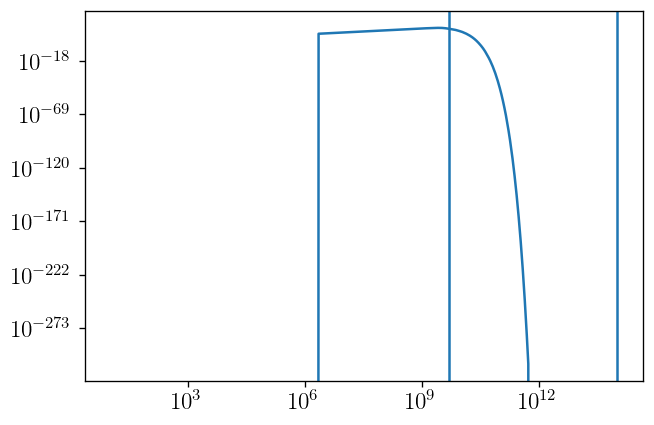

In [50]:
plt.plot(sec_spec['E'], sec_spec['dN_dEdt'][50])
plt.loglog()
plt.axvline(5e9)
plt.axvline(1e14)

In [54]:
spec_out = get_pppc_spec('q', in_spec, 'elec', binning['elecE'])
print(spec_out.toteng())
spec_out = get_pppc_spec('q', in_spec, 'phot', binning['photE'])
print(spec_out.toteng())

5.706458899588104e+30
1.0539266721650763e+31


In [49]:
spec_out.toteng()

5.706458899588104e+30

In [6]:
binning = load_data('binning')

In [14]:
np.min(binning['elecE'])

1.029782576544676

In [15]:
eng = np.copy(binning['elecE'])
mDM = 1e7

log10x = np.log10(eng/mDM)

# Refine the binning so that the spectrum is accurate. 
# Do this by checking that in the relevant range, there are at
# least 50,000 bins. If not, double (unless an absurd number
# of bins already).
if (
    log10x[(log10x < 1) & (log10x > 1e-9)].size > 0
    and log10x.size < 500000
):
    while log10x[(log10x < 1) & (log10x > 1e-9)].size < 50000:
        log10x = np.interp(
            np.arange(0, log10x.size-0.5, 0.5), 
            np.arange(log10x.size), 
            log10x
        )
        print(log10x.size)
# Get the interpolator. 
dlNdlxIEW_interp = load_data('pppc')


999
1997
3993
7985
15969
31937
63873
127745
255489
510977
1021953


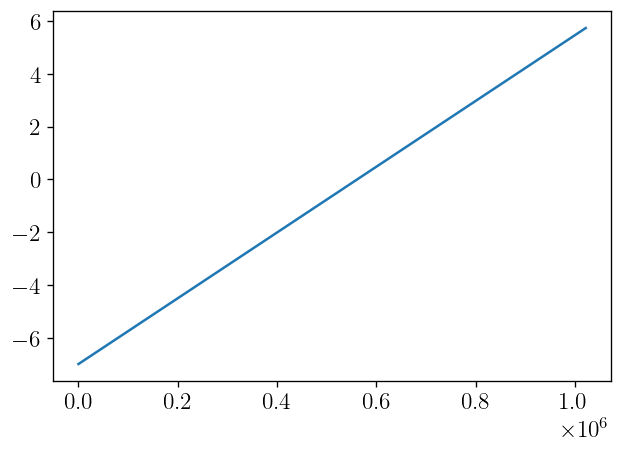

In [16]:
plt.plot(log10x)

In [ ]:

# Get the spectrum from the interpolator.
dN_dlog10x = 10**dlNdlxIEW_interp[sec][pri].get_val(mDM/1e9, log10x)

# Recall that dN/dE = dN/dlog10x * dlog10x/dE
x = 10**log10x
spec = Spectrum(x*mDM, dN_dlog10x/(x*mDM*np.log(10)), spec_type='dNdE')

# Rebin down to the original binning.

# The highest bin of spec.eng should be the same as eng[-1], based on
# the interpolation strategy above. However, sometimes a floating point
# error is picked up. We'll get rid of this so that rebin doesn't
# complain.
spec.eng[-1] = eng[-1]
spec.rebin(eng)

In [20]:
import json
data_path = os.environ['DH_DATA_DIR']
print(data_path)

/n/holystore01/LABS/iaifi_lab/Users/yitians/darkhistory/DHdata_hdf5/full


In [21]:
coords_data = np.array(json.load(open(data_path+'/dlNdlxIEW_coords_table.json')), dtype=object)

In [ ]:
coords_data

In [4]:
load_data('pppc')

{'elec': {'e_L': <darkhistory.config.PchipInterpolator2D at 0x7f7a037a59d0>,
  'e_R': <darkhistory.config.PchipInterpolator2D at 0x7f79fb404b50>,
  'e': <darkhistory.config.PchipInterpolator2D at 0x7f79f9426910>,
  'mu_L': <darkhistory.config.PchipInterpolator2D at 0x7f79f9426ad0>,
  'mu_R': <darkhistory.config.PchipInterpolator2D at 0x7f79f9426e10>,
  'mu': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427090>,
  'tau_L': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427250>,
  'tau_R': <darkhistory.config.PchipInterpolator2D at 0x7f79f94275d0>,
  'tau': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427850>,
  'q': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427a10>,
  'c': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427d50>,
  'b': <darkhistory.config.PchipInterpolator2D at 0x7f79f9427fd0>,
  't': <darkhistory.config.PchipInterpolator2D at 0x7f79f92f0290>,
  'W_L': <darkhistory.config.PchipInterpolator2D at 0x7f79f92f0510>,
  'W_T': <darkhistory.config.Pc